In [184]:
import pandas as pd
import datetime
import pandas_datareader.data as web
import math

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [185]:
# Data Collection
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2017, 1, 11)
df = web.DataReader("AAPL", 'yahoo', start, end)

In [186]:
# Feature Engineering

dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [187]:
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
#dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
dfreg['label'] = dfreg[forecast_col]
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_test = X[-forecast_out:]
X_train = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y_train = y[:-forecast_out]
y_test = y[-forecast_out:]

In [188]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=4)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [189]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)

In [190]:
# results
print('The linear regression confidence is {}'.format(confidencereg))
print('The quadratic regression 2 confidence is {}'.format(confidencepoly2))
print('The quadratic regression 3 confidence is {}'.format(confidencepoly3))
print('The knn regression confidence is {}'.format(confidenceknn))

The linear regression confidence is 1.0
The quadratic regression 2 confidence is 0.9997088447891292
The quadratic regression 3 confidence is 0.9995051312986734
The knn regression confidence is -1.7365954136723167


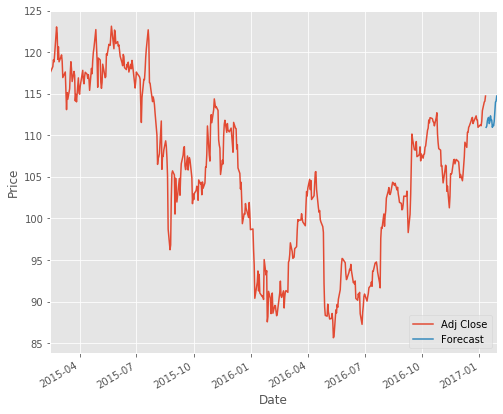

In [191]:
# LinearRegression Prediction Visualization 

forecast_set = clfreg.predict(X_test)
dfreg['Forecast'] = np.nan

last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()